# Importing Results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
from utils import make_test_set_esnli, make_test_set_mnli, make_test_set_cose

NUM_EXPL = 100

dataset_esnli = make_test_set_esnli(size=NUM_EXPL) # 9830 is dev size esnli (originally 9842 but 12 instance are wrongly annotated)
dataset_mnli = make_test_set_mnli(size=NUM_EXPL) # 9815 is dev size mnli
dataset_cose = make_test_set_cose(size=NUM_EXPL) # 718 (originally 1221 is dev size cose but 503 instances have bad explanations, i.e. the whole question highlighted))

Found cached dataset multi_nli (/Users/henningheyen/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset cos_e (/Users/henningheyen/.cache/huggingface/datasets/cos_e/v1.11/1.11.0/e8dc57a5b321a2a97063efb8d316d6d8a0d9a2d3a392dafc913e55bed42736d2)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
# Importing results calculated on Colab servers
import json


# Read the file
with open('results/json/explainability_results_mnli.json', 'r') as f:
    explainability_results_mnli = json.load(f)

# Read the file
with open('results/json/explainability_results_esnli.json', 'r') as f:
    explainability_results_esnli = json.load(f)

# Read the file
with open('results/json/explainability_results_cose_wo_large.json', 'r') as f:
    explainability_results_cose_wo_large = json.load(f)

# Read the file
with open('results/json/explainability_results_cose_large.json', 'r') as f:
    explainability_results_cose_large = json.load(f)

with open('results/json/predictions_for_explanations.json', 'r') as f:
    predictions_for_explanations = json.load(f)


In [4]:
# Merging cose results
explainability_results_cose = explainability_results_cose_wo_large
explainability_results_cose['cose']['large'] = explainability_results_cose_large['cose']['large']


In [5]:
def print_key_tree(d, indent=0):
    for key, value in d.items():
        print('  ' * indent + str(key) + ": " + str(type(value)))
        if isinstance(value, dict):
            print_key_tree(value, indent + 1)
        elif isinstance(value, list):
            if all(isinstance(i, dict) for i in value):
                for sub_dict in value:
                    print_key_tree(sub_dict, indent + 1)

In [6]:
print_key_tree(explainability_results_esnli['esnli'])

xsmall: <class 'dict'>
  explanations_as_list: <class 'list'>
  faithfulness: <class 'dict'>
    comprehensiveness: <class 'list'>
    macro_comprehensiveness: <class 'float'>
    sufficiency: <class 'list'>
    macro_sufficiency: <class 'float'>
  plausibility: <class 'dict'>
    iou: <class 'list'>
    macro_iou: <class 'float'>
    tokenf1: <class 'list'>
    macro_tokenf1: <class 'float'>
small: <class 'dict'>
  explanations_as_list: <class 'list'>
  faithfulness: <class 'dict'>
    comprehensiveness: <class 'list'>
    macro_comprehensiveness: <class 'float'>
    sufficiency: <class 'list'>
    macro_sufficiency: <class 'float'>
  plausibility: <class 'dict'>
    iou: <class 'list'>
    macro_iou: <class 'float'>
    tokenf1: <class 'list'>
    macro_tokenf1: <class 'float'>
base: <class 'dict'>
  explanations_as_list: <class 'list'>
  faithfulness: <class 'dict'>
    comprehensiveness: <class 'list'>
    macro_comprehensiveness: <class 'float'>
    sufficiency: <class 'list'>
   

In [7]:
# all in one dictionary:
explainability_results = {}
explainability_results['mnli'] = explainability_results_mnli['mnli']
explainability_results['esnli'] = explainability_results_esnli['esnli']
explainability_results['cose'] = explainability_results_cose['cose']



In [8]:
model_names = ['xsmall', 'small', 'base', 'large']
model_sizes = ['xsmall (22m)', 'small (44m)', 'base (86m) ', 'large (304m)']
datasets = ['esnli', 'mnli', 'cose']
dataset_labels = ['e-SNLI', 'MNLI', 'CoS-e']

In [9]:
# Indices by labels
contradiction_idx_esnli = [i for i in range(NUM_EXPL) if dataset_esnli['test_labels_text'][i] == 'contradiction']
entailment_idx_esnli = [i for i in range(NUM_EXPL) if dataset_esnli['test_labels_text'][i] == 'entailment']
neutral_idx_esnli = [i for i in range(NUM_EXPL) if dataset_esnli['test_labels_text'][i] == 'neutral']

contradiction_idx_mnli = [i for i in range(NUM_EXPL) if dataset_mnli['test_labels_text'][i] == 'contradiction']
entailment_idx_mnli = [i for i in range(NUM_EXPL) if dataset_mnli['test_labels_text'][i] == 'entailment']
neutral_idx_mnli = [i for i in range(NUM_EXPL) if dataset_mnli['test_labels_text'][i] == 'neutral']

explainability_results['mnli']['indices'] = {'contradiction_idx': contradiction_idx_mnli, 'entailment_idx': entailment_idx_mnli, 'neutral_idx': neutral_idx_mnli}
explainability_results['esnli']['indices'] = {'contradiction_idx': contradiction_idx_esnli, 'entailment_idx': entailment_idx_esnli, 'neutral_idx': neutral_idx_esnli}

In [10]:
# Indices by correct predicition

for dataset in datasets:
    for model_name in model_names:
        explainability_results[dataset][model_name]['correct_idx'] = [True if predictions_for_explanations[dataset]['true'][i] == predictions_for_explanations[dataset][model_name]['pred'][i] else False for i in range(NUM_EXPL)]

In [12]:
import numpy as np

def get_sem(list): # standard error of the mean 
    std_dev = np.std(list)
    n = len(list)
    return std_dev / np.sqrt(n)

In [13]:
# splitting by label
for dataset in ['mnli', 'esnli']:
    for model_name in model_names:

        comp = explainability_results[dataset][model_name]['faithfulness']['comprehensiveness']
        explainability_results[dataset][model_name]['faithfulness']['comp_contradiction'] = [comp[i] for i in explainability_results[dataset]['indices']['contradiction_idx']]
        explainability_results[dataset][model_name]['faithfulness']['comp_entailment'] = [comp[i] for i in explainability_results[dataset]['indices']['entailment_idx']]
        explainability_results[dataset][model_name]['faithfulness']['comp_neutral'] = [comp[i] for i in explainability_results[dataset]['indices']['neutral_idx']]

        suff = explainability_results[dataset][model_name]['faithfulness']['sufficiency']
        explainability_results[dataset][model_name]['faithfulness']['suff_contradiction'] = [suff[i] for i in explainability_results[dataset]['indices']['contradiction_idx']]
        explainability_results[dataset][model_name]['faithfulness']['suff_entailment'] = [suff[i] for i in explainability_results[dataset]['indices']['entailment_idx']]
        explainability_results[dataset][model_name]['faithfulness']['suff_neutral'] = [suff[i] for i in explainability_results[dataset]['indices']['neutral_idx']]


In [15]:
# splitting by prediction
for dataset in datasets:
    for model_name in model_names:
        explainability_results[dataset][model_name]['faithfulness']['sem_comp'] = get_sem(explainability_results[dataset][model_name]['faithfulness']['comprehensiveness'])
        explainability_results[dataset][model_name]['faithfulness']['sem_suff'] = get_sem(explainability_results[dataset][model_name]['faithfulness']['sufficiency'])
        if dataset != 'mnli':
            explainability_results[dataset][model_name]['plausibility']['sem_iou'] = get_sem(explainability_results[dataset][model_name]['plausibility']['iou'])
            explainability_results[dataset][model_name]['plausibility']['sem_tokenf1'] = get_sem(explainability_results[dataset][model_name]['plausibility']['tokenf1'])

## Gloabl Faithfulness

/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_89867/136132416.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'Comprehensiveness - {label}', capsize=3, marker='o', color=color)
/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_89867/136132416.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o--" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o--', label=f'Sufficiency - {label}', capsize=3, marker='o', color=color)


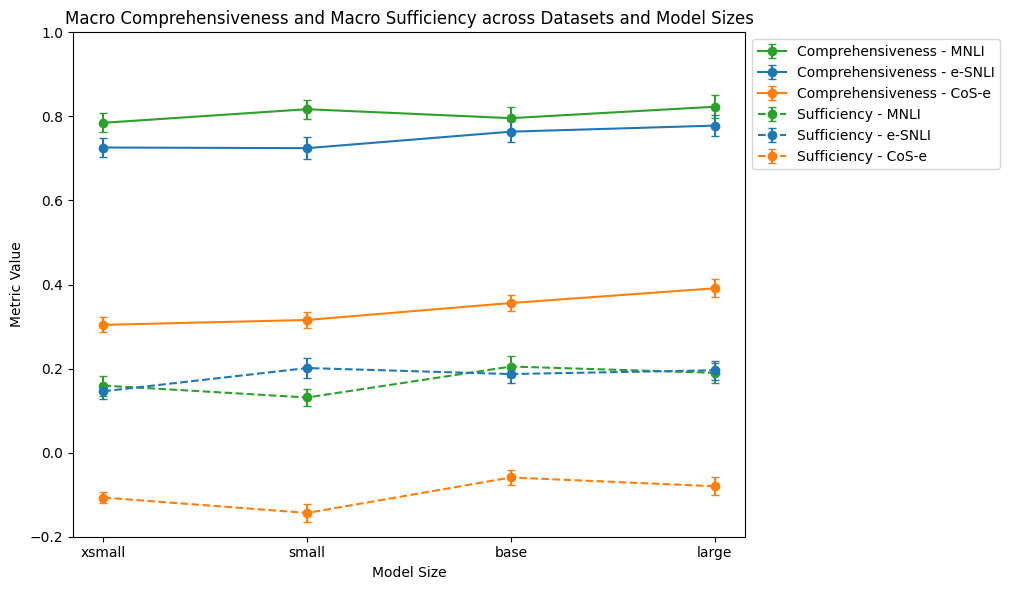

In [16]:
import matplotlib.pyplot as plt

# Create a single figure
plt.figure(figsize=(12, 6))

datasets = ['mnli', 'esnli', 'cose']
dataset_labels = ['MNLI', 'e-SNLI', 'CoS-e']
dataset_colors = ['tab:green', 'tab:blue', 'tab:orange']
model_sizes = ['xsmall', 'small', 'base', 'large']

# Plotting macro_comprehensiveness with SEM
for dataset, label, color in zip(datasets, dataset_labels, dataset_colors):
    y_values = [explainability_results[dataset][model_name]['faithfulness']['macro_comprehensiveness'] for model_name in model_sizes]
    y_errors = [explainability_results[dataset][model_name]['faithfulness']['sem_comp'] for model_name in model_sizes]
    plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'Comprehensiveness - {label}', capsize=3, marker='o', color=color)

# Plotting macro_sufficiency with SEM
for dataset, label, color in zip(datasets, dataset_labels, dataset_colors):
    y_values = [explainability_results[dataset][model_name]['faithfulness']['macro_sufficiency'] for model_name in model_sizes]
    y_errors = [explainability_results[dataset][model_name]['faithfulness']['sem_suff'] for model_name in model_sizes]
    plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o--', label=f'Sufficiency - {label}', capsize=3, marker='o', color=color)

plt.ylim(-0.2, 1)
plt.xlabel('Model Size')
plt.ylabel('Metric Value')
plt.title('Macro Comprehensiveness and Macro Sufficiency across Datasets and Model Sizes')

# Place the legend outside the plot area
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
plt.show()


/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_89867/3550314090.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  axes[0].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=label, capsize=3, marker='o')
/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_89867/3550314090.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  axes[1].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=label, capsize=3, marker='o')


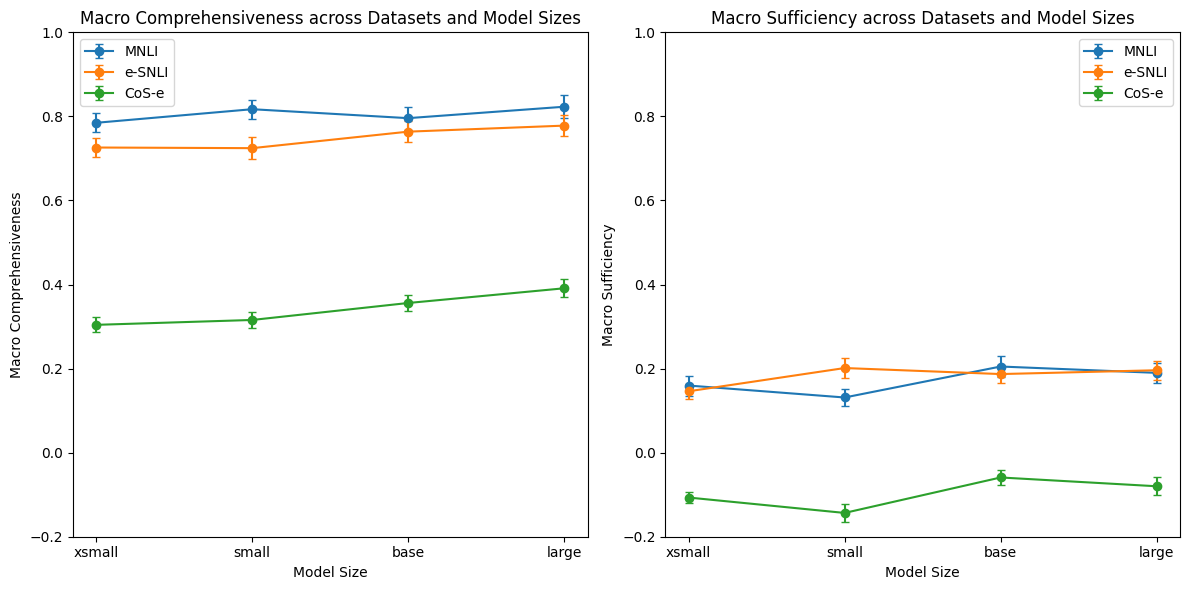

In [17]:
import matplotlib.pyplot as plt

# Create a single figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting macro_comprehensiveness with SEM
for dataset, label in zip(datasets, dataset_labels):
    y_values = [explainability_results[dataset][model_name]['faithfulness']['macro_comprehensiveness'] for model_name in model_names]
    y_errors = [explainability_results[dataset][model_name]['faithfulness']['sem_comp'] for model_name in model_names]
    axes[0].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=label, capsize=3, marker='o')

axes[0].set_ylim(-0.2, 1)
axes[0].set_xlabel('Model Size')
axes[0].set_ylabel('Macro Comprehensiveness')
axes[0].set_title('Macro Comprehensiveness across Datasets and Model Sizes')
axes[0].legend()

# Plotting macro_sufficiency with SEM
for dataset, label in zip(datasets, dataset_labels):
    y_values = [explainability_results[dataset][model_name]['faithfulness']['macro_sufficiency'] for model_name in model_names]
    y_errors = [explainability_results[dataset][model_name]['faithfulness']['sem_suff'] for model_name in model_names]
    axes[1].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=label, capsize=3, marker='o')

axes[1].set_ylim(-0.2, 1)
axes[1].set_xlabel('Model Size')
axes[1].set_ylabel('Macro Sufficiency')
axes[1].set_title('Macro Sufficiency across Datasets and Model Sizes')
axes[1].legend()

plt.tight_layout()
plt.show()

# Gloabl Plausiblty

/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_89867/341358485.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'IoU - {label}', capsize=3, marker='o', color=colors[dataset])
/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_89867/341358485.py:21: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o--" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o--', label=f'Token F1 - {label}', capsize=3, marker='o', color=colors[dataset])


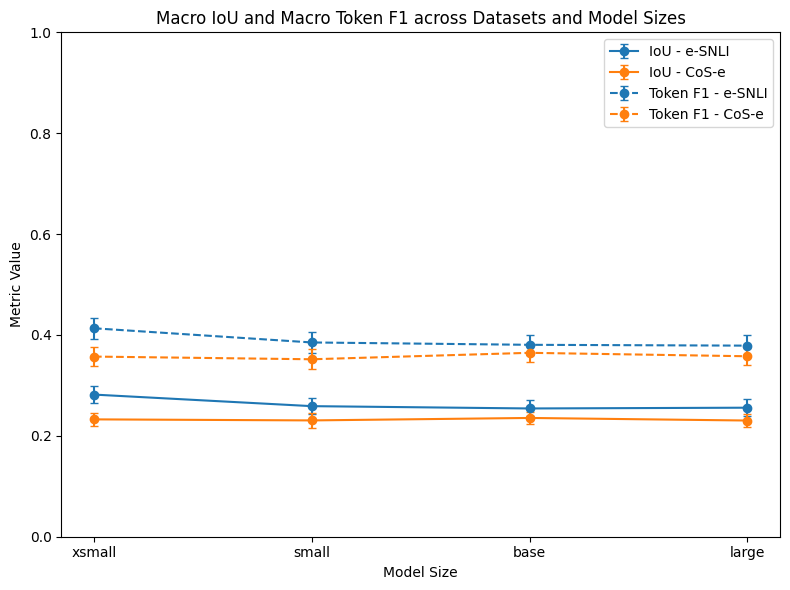

In [18]:
import matplotlib.pyplot as plt

# Create a single figure
plt.figure(figsize=(8, 6))

datasets = ['esnli', 'cose']
dataset_labels = ['e-SNLI', 'CoS-e']
model_sizes = ['xsmall', 'small', 'base', 'large']
colors = {'esnli': 'tab:blue', 'cose': 'tab:orange'}

# Plotting macro_iou with SEM
for dataset, label in zip(datasets, dataset_labels):
    y_values = [explainability_results[dataset][model_name]['plausibility']['macro_iou'] for model_name in model_sizes]
    y_errors = [explainability_results[dataset][model_name]['plausibility']['sem_iou'] for model_name in model_sizes]
    plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'IoU - {label}', capsize=3, marker='o', color=colors[dataset])

# Plotting macro_tokenf1 with SEM
for dataset, label in zip(datasets, dataset_labels):
    y_values = [explainability_results[dataset][model_name]['plausibility']['macro_tokenf1'] for model_name in model_sizes]
    y_errors = [explainability_results[dataset][model_name]['plausibility']['sem_tokenf1'] for model_name in model_sizes]
    plt.errorbar(model_sizes, y_values, yerr=y_errors, fmt='o--', label=f'Token F1 - {label}', capsize=3, marker='o', color=colors[dataset])

plt.ylim(0, 1)
plt.xlabel('Model Size')
plt.ylabel('Metric Value')
plt.title('Macro IoU and Macro Token F1 across Datasets and Model Sizes')
plt.legend()

plt.tight_layout()
plt.show()


/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_89867/2533888699.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  axes[0].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=label, capsize=3, marker='o')
/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_89867/2533888699.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  axes[1].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=label, capsize=3, marker='o')


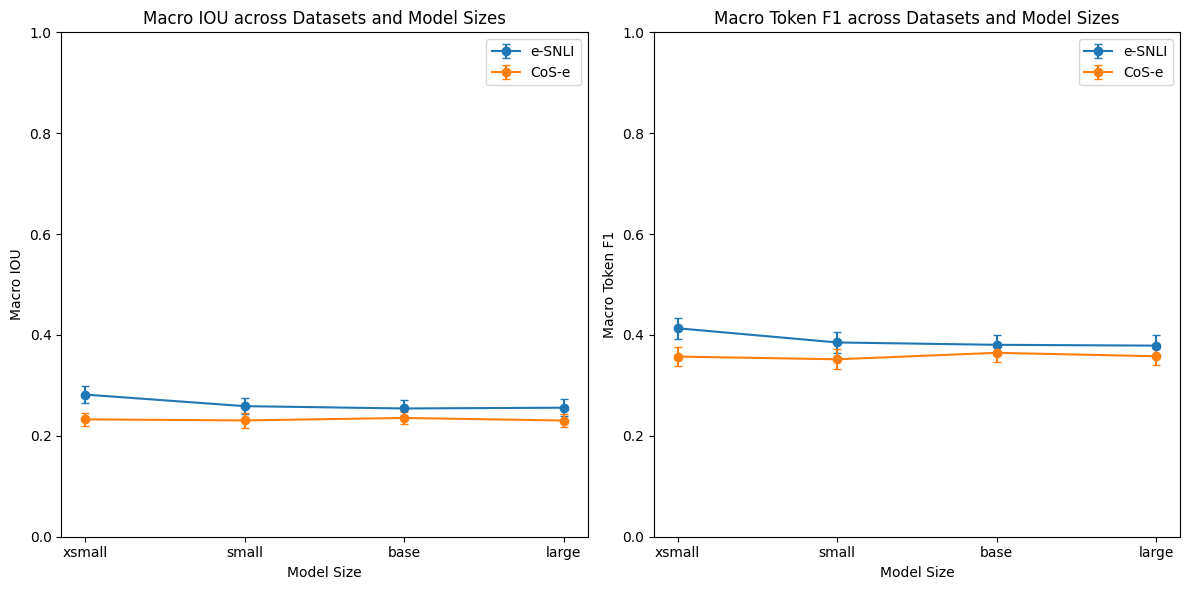

In [19]:
import matplotlib.pyplot as plt

# Create a single figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting macro_iou with SEM
for dataset, label in zip(datasets, dataset_labels):
    y_values = [explainability_results[dataset][model_name]['plausibility']['macro_iou'] for model_name in model_names]
    y_errors = [explainability_results[dataset][model_name]['plausibility']['sem_iou'] for model_name in model_names]
    axes[0].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=label, capsize=3, marker='o')

axes[0].set_ylim(0, 1)
axes[0].set_xlabel('Model Size')
axes[0].set_ylabel('Macro IOU')
axes[0].set_title('Macro IOU across Datasets and Model Sizes')
axes[0].legend()

# Plotting macro_tokenf1 with SEM
for dataset, label in zip(datasets, dataset_labels):
    y_values = [explainability_results[dataset][model_name]['plausibility']['macro_tokenf1'] for model_name in model_names]
    y_errors = [explainability_results[dataset][model_name]['plausibility']['sem_tokenf1'] for model_name in model_names]
    axes[1].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=label, capsize=3, marker='o')

axes[1].set_ylim(0, 1)
axes[1].set_xlabel('Model Size')
axes[1].set_ylabel('Macro Token F1')
axes[1].set_title('Macro Token F1 across Datasets and Model Sizes')
axes[1].legend()

plt.tight_layout()
plt.show()


## Global Metrics side by side:

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Create a single figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

datasets = ['mnli', 'esnli', 'cose']
dataset_labels = ['MNLI', 'e-SNLI', 'CoS-e']
dataset_colors = ['tab:green', 'tab:blue', 'tab:orange']
model_sizes = ['xsmall', 'small', 'base', 'large']
dodge_amounts = [-0.2, 0, 0.2]  # Adjust this value to change the amount of dodging

# ... [Rest of your setup code] ...

# First subplot: Macro Comprehensiveness and Macro Sufficiency
for dodge, dataset, label, color in zip(dodge_amounts, datasets, dataset_labels, dataset_colors):
    x_coords = [i + dodge for i in range(len(model_sizes))]
    # ... [Rest of your plotting code for the first subplot] ...

# ... [Rest of your plotting code for the second subplot] ...

# ... [Rest of your code for shadowed background, axis settings, and legend] ...

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
plt.show()


/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_89867/3124165382.py:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  axes[0].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'Comprehensiveness - {label}', capsize=3, marker='o', color=color)
/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_89867/3124165382.py:29: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o--" (-> marker='o'). The keyword argument will take precedence.
  axes[0].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o--', label=f'Sufficiency - {label}', capsize=3, marker='o', color=color)
/var/folders/mk/wzdjjhhs443f788pzxjfj5vc0000gn/T/ipykernel_89867/3124165382.py:55: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-." (-> marker='o'). The keyword argument will take prec

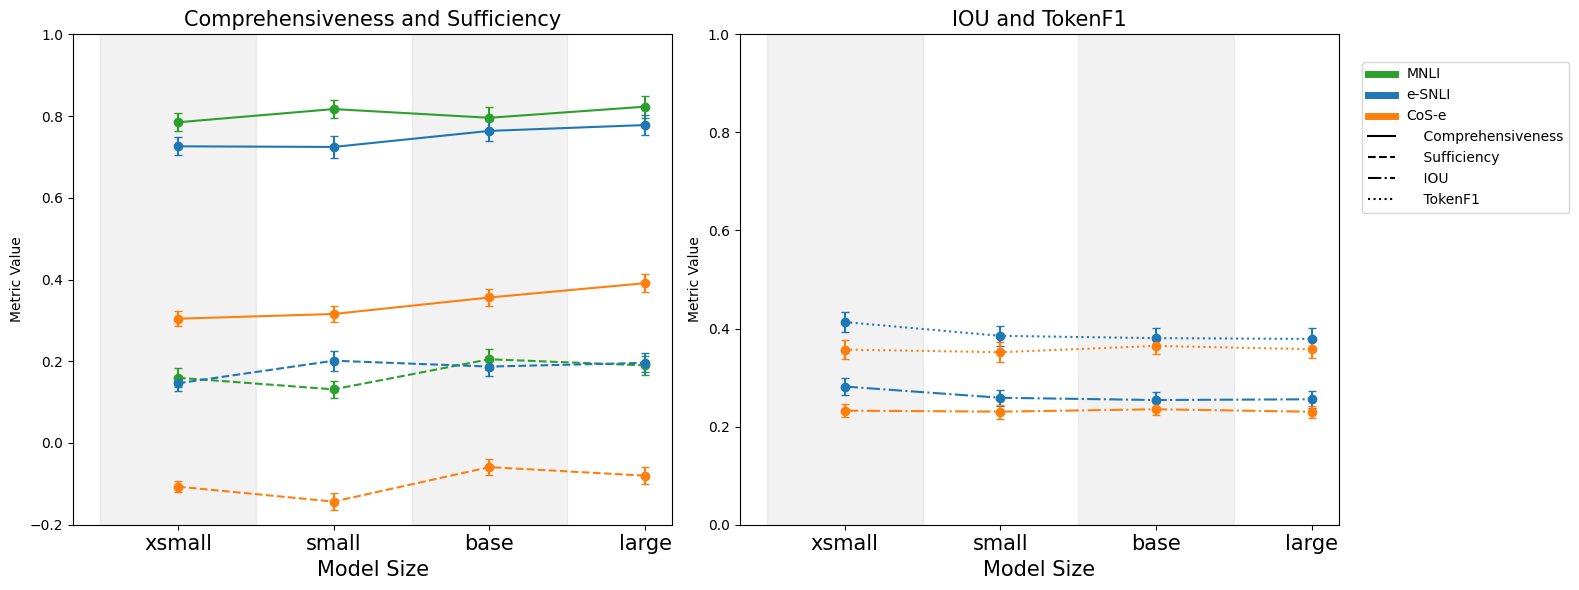

In [119]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Create a single figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

datasets = ['mnli', 'esnli', 'cose']
dataset_labels = ['MNLI', 'e-SNLI', 'CoS-e']
dataset_colors = ['tab:green', 'tab:blue', 'tab:orange']
model_sizes = ['xsmall', 'small', 'base', 'large']

# Create custom legend handles
color_legend = [mlines.Line2D([], [], color=color, label=label, lw=5) for color, label in zip(dataset_colors, dataset_labels)]
line_legend = [mlines.Line2D([], [], color='black', linestyle='-', label='    Comprehensiveness'),
               mlines.Line2D([], [], color='black', linestyle='--', label='    Sufficiency'),
               mlines.Line2D([], [], color='black', linestyle='-.', label='    IOU'),
               mlines.Line2D([], [], color='black', linestyle=':', label='    TokenF1')]


# First subplot: Macro Comprehensiveness and Macro Sufficiency
for dataset, label, color in zip(datasets, dataset_labels, dataset_colors):
    y_values = [explainability_results[dataset][model_name]['faithfulness']['macro_comprehensiveness'] for model_name in model_sizes]
    y_errors = [explainability_results[dataset][model_name]['faithfulness']['sem_comp'] for model_name in model_sizes]
    axes[0].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-', label=f'Comprehensiveness - {label}', capsize=3, marker='o', color=color)

for dataset, label, color in zip(datasets, dataset_labels, dataset_colors):
    y_values = [explainability_results[dataset][model_name]['faithfulness']['macro_sufficiency'] for model_name in model_sizes]
    y_errors = [explainability_results[dataset][model_name]['faithfulness']['sem_suff'] for model_name in model_sizes]
    axes[0].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o--', label=f'Sufficiency - {label}', capsize=3, marker='o', color=color)

# Add shadowed background for model size
for j, model in enumerate(model_names):
    if j % 2 == 0:
        axes[0].axvspan(j-0.5, j+0.5, color='gray', alpha=0.1)

axes[0].set_ylim(-0.2, 1)
axes[0].set_xlabel('Model Size', fontsize=15)
axes[0].set_ylabel('Metric Value')
axes[0].set_title('Comprehensiveness and Sufficiency', fontsize=15)

# Set the font size for x-axis labels
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_fontsize(15)

# Second subplot: Macro IoU and Macro Token F1
datasets = ['esnli', 'cose']
dataset_labels = ['e-SNLI', 'CoS-e']
colors = {'esnli': 'tab:blue', 'cose': 'tab:orange'}


for dataset, label in zip(datasets, dataset_labels):
    y_values = [explainability_results[dataset][model_name]['plausibility']['macro_iou'] for model_name in model_sizes]
    y_errors = [explainability_results[dataset][model_name]['plausibility']['sem_iou'] for model_name in model_sizes]
    axes[1].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o-.', label=f'IOU - {label}', capsize=3, marker='o', color=colors[dataset])

for dataset, label in zip(datasets, dataset_labels):
    y_values = [explainability_results[dataset][model_name]['plausibility']['macro_tokenf1'] for model_name in model_sizes]
    y_errors = [explainability_results[dataset][model_name]['plausibility']['sem_tokenf1'] for model_name in model_sizes]
    axes[1].errorbar(model_sizes, y_values, yerr=y_errors, fmt='o:', label=f'TokenF1 - {label}', capsize=3, marker='o', color=colors[dataset])

# Add shadowed background for model size
for j, model in enumerate(model_names):
    if j % 2 == 0:
        axes[1].axvspan(j-0.5, j+0.5, color='gray', alpha=0.1)

axes[1].set_ylim(0, 1)
axes[1].set_xlabel('Model Size', fontsize=15)
axes[1].set_ylabel('Metric Value')
axes[1].set_title('IOU and TokenF1', fontsize=15)

# Place the custom legend outside the plot area
fig.legend(handles=color_legend + line_legend, loc='upper left', bbox_to_anchor=(0.85, 0.9))

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
plt.show()

## Faithfulness by Label

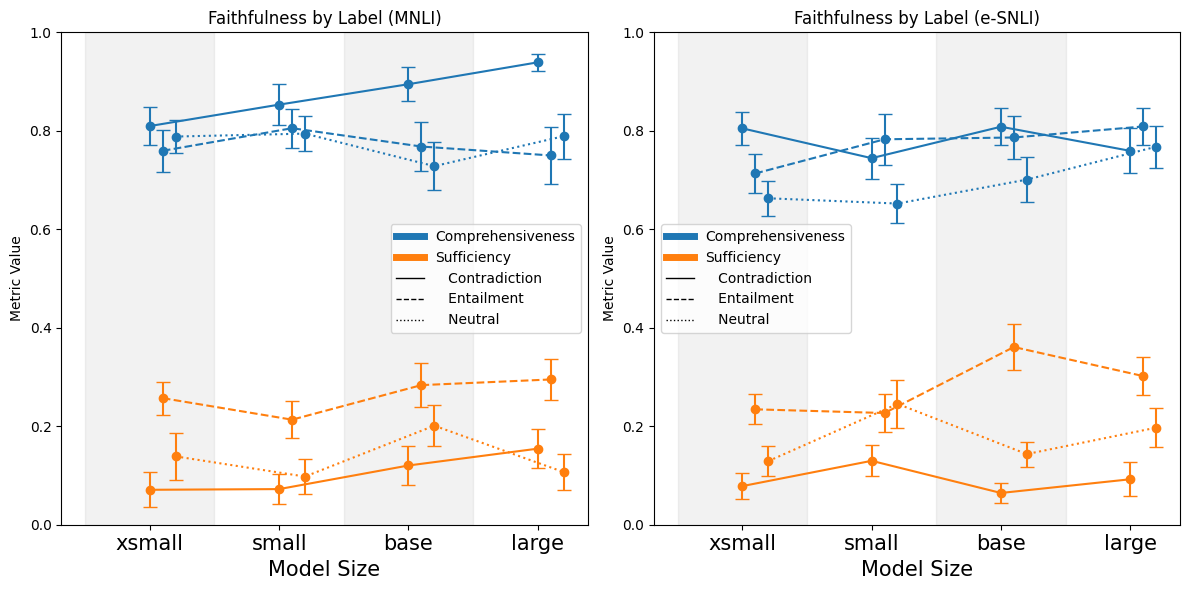

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Your dictionary, replace with the actual data
# explainability_results = ...

# Function to get SEM
def get_sem(data_list):
    return np.std(data_list) / np.sqrt(len(data_list))

model_names = ['xsmall', 'small', 'base', 'large']
labels = ['contradiction', 'entailment', 'neutral']
dataset_names = ['MNLI', 'e-SNLI']
line_styles = ['-', '--', ':']

dodge_amount = 0.1  # Adjust this value to change the amount of dodging

plt.figure(figsize=(12, 6))

for i, dataset in enumerate(['mnli', 'esnli']):
    plt.subplot(1, 2, i+1)
    
    for j, label in enumerate(labels):
        means_comp = []
        sems_comp = []
        means_suff = []
        sems_suff = []
        
        for model_name in model_names:
            comp_key = f'comp_{label}'
            suff_key = f'suff_{label}'
            
            mean_comp = np.mean(explainability_results[dataset][model_name]['faithfulness'][comp_key])
            sem_comp = get_sem(explainability_results[dataset][model_name]['faithfulness'][comp_key])
            
            mean_suff = np.mean(explainability_results[dataset][model_name]['faithfulness'][suff_key])
            sem_suff = get_sem(explainability_results[dataset][model_name]['faithfulness'][suff_key])
            
            means_comp.append(mean_comp)
            sems_comp.append(sem_comp)
            means_suff.append(mean_suff)
            sems_suff.append(sem_suff)
        
        # Dodge the x-coordinates
        x_coords_comp = np.arange(len(model_names)) + j*dodge_amount
        x_coords_suff = np.arange(len(model_names)) + j*dodge_amount
        
        plt.errorbar(x_coords_comp, means_comp, yerr=sems_comp, linestyle=line_styles[j], marker='o', color='tab:blue', capsize=5)
        plt.errorbar(x_coords_suff, means_suff, yerr=sems_suff, linestyle=line_styles[j], marker='o', color='tab:orange', capsize=5)
    

        # Add shadowed background for each category
    for j, model in enumerate(model_names):
        if j % 2 == 0:
            plt.axvspan(j-0.5, j+0.5, color='gray', alpha=0.1)
            
    plt.ylim(0,1)
    plt.xlabel('Model Size', fontsize=15)
    plt.ylabel('Metric Value')
    plt.title(f'Faithfulness by Label ({dataset_names[i]})')
    plt.xticks(ticks=np.arange(len(model_names)), labels=model_names, fontsize=15)  # Set x-tick labels to model names
    
    # Create custom legend
    custom_lines = [Line2D([0], [0], color='tab:blue', lw=5),
                    Line2D([0], [0], color='tab:orange', lw=5),
                    Line2D([0], [0], color='black', linestyle='-', lw=1),
                    Line2D([0], [0], color='black', linestyle='--', lw=1),
                    Line2D([0], [0], color='black', linestyle=':', lw=1)]
    
    plt.legend(custom_lines, ['Comprehensiveness', 'Sufficiency', '   Contradiction', '   Entailment', '   Neutral'])

plt.tight_layout()
plt.show()


## Faithfulness by Prediction

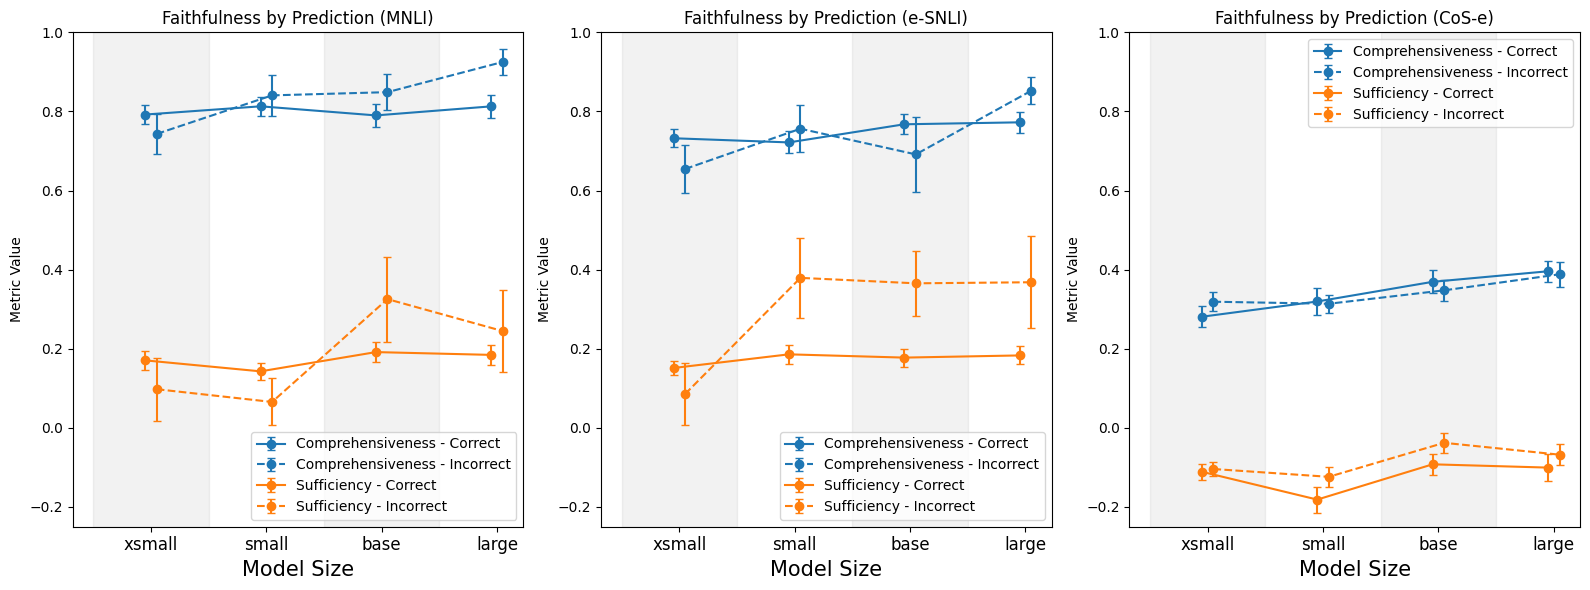

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

model_names = ['xsmall', 'small', 'base', 'large']
dataset_names = ['MNLI', 'e-SNLI', 'CoS-e']
line_styles = ['-', '--', ':']
dodge_amount = 0.05  # Adjust this value to change the amount of dodging

plt.figure(figsize=(16, 6))

for i, dataset in enumerate(['mnli', 'esnli', 'cose']):
    plt.subplot(1, 3, i+1)
    
    mean_comp_correct = []
    mean_comp_incorrect = []
    mean_suff_correct = []
    mean_suff_incorrect = []
    
    sem_comp_correct = []
    sem_comp_incorrect = []
    sem_suff_correct = []
    sem_suff_incorrect = []
    
    for model_name in model_names:
        comp = np.array(explainability_results[dataset][model_name]['faithfulness']['comprehensiveness'])
        suff = np.array(explainability_results[dataset][model_name]['faithfulness']['sufficiency'])
        correct_idx = np.array(explainability_results[dataset][model_name]['correct_idx'])
        
        comp_correct = comp[correct_idx]
        comp_incorrect = comp[~correct_idx]
        
        suff_correct = suff[correct_idx]
        suff_incorrect = suff[~correct_idx]
        
        mean_comp_correct.append(np.mean(comp_correct))
        mean_comp_incorrect.append(np.mean(comp_incorrect))
        
        mean_suff_correct.append(np.mean(suff_correct))
        mean_suff_incorrect.append(np.mean(suff_incorrect))
        
        sem_comp_correct.append(get_sem(comp_correct))
        sem_comp_incorrect.append(get_sem(comp_incorrect))
        
        sem_suff_correct.append(get_sem(suff_correct))
        sem_suff_incorrect.append(get_sem(suff_incorrect))

    x_coords = np.arange(len(model_names))
    
    # Add shadowed background for model size
    for j, model in enumerate(model_names):
        if j % 2 == 0:
            plt.axvspan(j-0.5, j+0.5, color='gray', alpha=0.1)
    
    plt.errorbar(x_coords - dodge_amount, mean_comp_correct, yerr=sem_comp_correct, linestyle='-', marker='o', color='tab:blue', label='Comprehensiveness - Correct', capsize=3)
    plt.errorbar(x_coords + dodge_amount, mean_comp_incorrect, yerr=sem_comp_incorrect, linestyle='--', marker='o', color='tab:blue', label='Comprehensiveness - Incorrect', capsize=3)
    
    plt.errorbar(x_coords - dodge_amount, mean_suff_correct, yerr=sem_suff_correct, linestyle='-', marker='o', color='tab:orange', label='Sufficiency - Correct', capsize=3)
    plt.errorbar(x_coords + dodge_amount, mean_suff_incorrect, yerr=sem_suff_incorrect, linestyle='--', marker='o', color='tab:orange', label='Sufficiency - Incorrect', capsize=3)
    
    plt.ylim(-0.25,1)
    plt.xlabel('Model Size', fontsize=15)
    plt.ylabel('Metric Value')
    plt.title(f'Faithfulness by Prediction ({dataset_names[i]})')
    plt.xticks(ticks=x_coords, labels=model_names, fontsize=12)  # Set x-tick labels to model names
    
    plt.legend()

plt.tight_layout()
plt.show()


## Plausiblity by Prediction

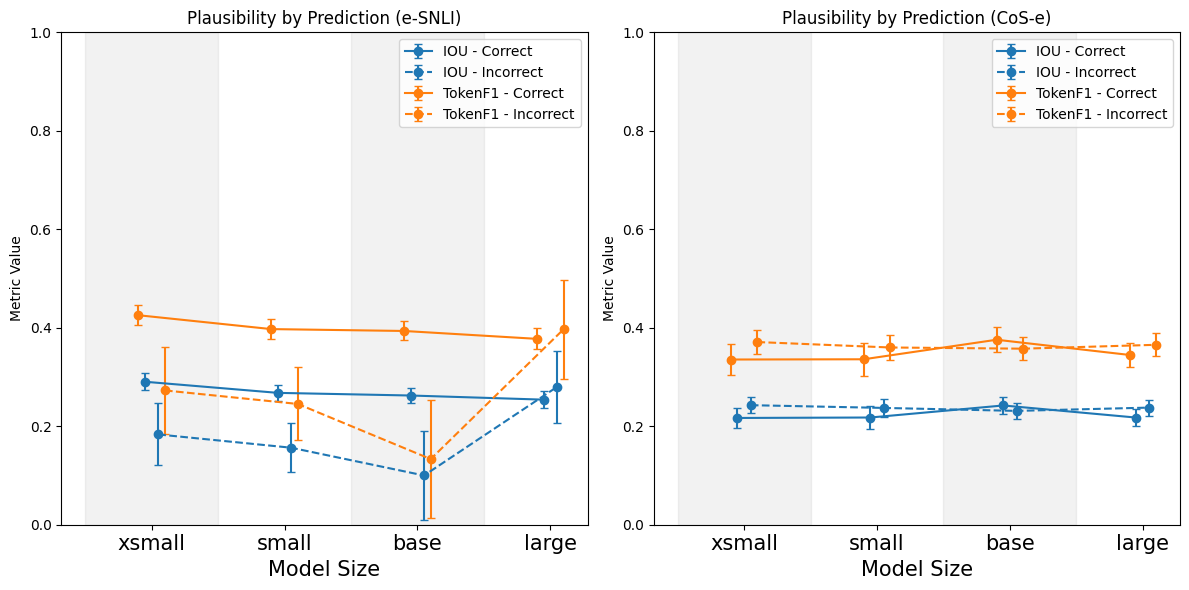

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Your dictionary, replace with the actual data
# explainability_results = ...

def get_sem(data_list):
    # Function to get SEM
    return np.std(data_list) / np.sqrt(len(data_list))

model_names = ['xsmall', 'small', 'base', 'large']
dataset_names = ['e-SNLI', 'CoS-e']
line_styles = ['-', '--', ':']
dodge_amount1 = 0.05  # Adjust this value to change the amount of dodging
dodge_amount2 = 0.1  # Adjust this value to change the amount of dodging

plt.figure(figsize=(12, 6))

for i, dataset in enumerate(['esnli', 'cose']):
    plt.subplot(1, 2, i+1)
    
    mean_iou_correct = []
    mean_iou_incorrect = []
    mean_tokenf1_correct = []
    mean_tokenf1_incorrect = []
    
    sem_iou_correct = []
    sem_iou_incorrect = []
    sem_tokenf1_correct = []
    sem_tokenf1_incorrect = []
    
    for model_name in model_names:
        iou = np.array(explainability_results[dataset][model_name]['plausibility']['iou'])
        tokenf1 = np.array(explainability_results[dataset][model_name]['plausibility']['tokenf1'])
        correct_idx = np.array(explainability_results[dataset][model_name]['correct_idx'])
        
        iou_correct = iou[correct_idx]
        iou_incorrect = iou[~correct_idx]
        
        tokenf1_correct = tokenf1[correct_idx]
        tokenf1_incorrect = tokenf1[~correct_idx]

        mean_iou_correct.append(np.mean(iou_correct))
        mean_iou_incorrect.append(np.mean(iou_incorrect))
        
        mean_tokenf1_correct.append(np.mean(tokenf1_correct))
        mean_tokenf1_incorrect.append(np.mean(tokenf1_incorrect))
        
        sem_iou_correct.append(get_sem(iou_correct))
        sem_iou_incorrect.append(get_sem(iou_incorrect))
        
        sem_tokenf1_correct.append(get_sem(tokenf1_correct))
        sem_tokenf1_incorrect.append(get_sem(tokenf1_incorrect))
    
    x_coords = np.arange(len(model_names))

    # Add shadowed background for model size
    for j, model in enumerate(model_names):
        if j % 2 == 0:
            plt.axvspan(j-0.5, j+0.5, color='gray', alpha=0.1)
    
    plt.errorbar(x_coords - dodge_amount1, mean_iou_correct, yerr=sem_iou_correct, linestyle='-', marker='o', color='tab:blue', label='IOU - Correct', capsize=3)
    plt.errorbar(x_coords + dodge_amount1, mean_iou_incorrect, yerr=sem_iou_incorrect, linestyle='--', marker='o', color='tab:blue', label='IOU - Incorrect', capsize=3)
    
    plt.errorbar(x_coords - dodge_amount2, mean_tokenf1_correct, yerr=sem_tokenf1_correct, linestyle='-', marker='o', color='tab:orange', label='TokenF1 - Correct', capsize=3)
    plt.errorbar(x_coords + dodge_amount2, mean_tokenf1_incorrect, yerr=sem_tokenf1_incorrect, linestyle='--', marker='o', color='tab:orange', label='TokenF1 - Incorrect', capsize=3)
    
    plt.ylim(0,1)
    plt.xlabel('Model Size', fontsize=15)
    plt.ylabel('Metric Value')
    plt.title(f'Plausibility by Prediction ({dataset_names[i]})')
    plt.xticks(ticks=x_coords, labels=model_names, fontsize=15)  # Set x-tick labels to model names
    
    plt.legend()

plt.tight_layout()
plt.show()


## Plausiblity by Label

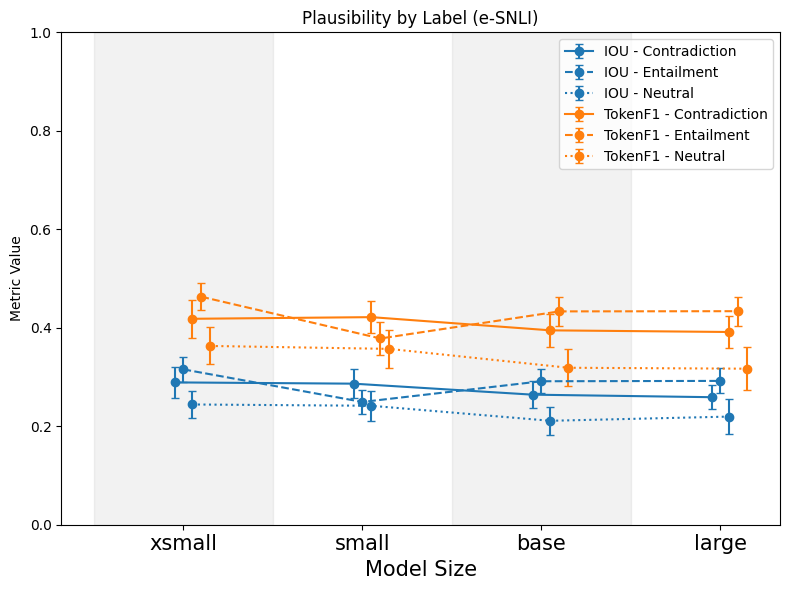

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Function to get SEM
def get_sem(data_list):
    return np.std(data_list) / np.sqrt(len(data_list))

model_names = ['xsmall', 'small', 'base', 'large']
labels = ['Contradiction', 'Entailment', 'Neutral']

plt.figure(figsize=(8, 6))

# Focusing only on e-SNLI dataset
dataset = 'esnli'
plt.title(f'Plausibility by Label (e-SNLI)')

metrics = ['IOU', 'TokenF1']
colors = ['tab:blue', 'tab:orange']
linestyles = ['-', '--', ':']

dodge_amount = 0.05  # Adjust this value to change the amount of dodging

for metric_idx, (metric, color) in enumerate(zip(metrics, colors)):
    for label_idx, label in enumerate(labels):
        means = []
        sems = []
        for model_name in model_names:
            data = np.array(explainability_results[dataset][model_name]['plausibility'][metric.lower()])
            label_indices = np.array(explainability_results[dataset]['indices'][f'{label.lower()}_idx'])
            
            means.append(np.mean(data[label_indices]))
            sems.append(get_sem(data[label_indices]))
        
        # Dodge the x-coordinates
        x_coords = np.arange(len(model_names)) + (label_idx - 1) * dodge_amount + metric_idx * dodge_amount * 2
        plt.errorbar(x_coords, means, yerr=sems, linestyle=linestyles[label_idx], marker='o', color=color, label=f'{metric} - {label}', capsize=3)

# Add shadowed background for model size
for j, model in enumerate(model_names):
    if j % 2 == 0:
        plt.axvspan(j-0.5, j+0.5, color='gray', alpha=0.1)

plt.ylim(0,1)
plt.xlabel('Model Size', fontsize=15)
plt.ylabel('Metric Value')
plt.xticks(ticks=np.arange(len(model_names)), labels=model_names, fontsize=15)  # Set x-tick labels to model names
plt.legend()

plt.tight_layout()
plt.show()


# Tables

In [31]:
import pandas as pd

# Initialize variables
model_names = ['xsmall', 'small', 'base', 'large']
dataset_labels = ['MNLI', 'e-SNLI', 'CoS-e']
datasets = ['mnli', 'esnli', 'cose']

# Initialize data list
data = []

# Loop through datasets and model names to populate the data list
for dataset, label in zip(datasets, dataset_labels):
    for model_name in model_names:
        macro_comprehensiveness = round(explainability_results[dataset][model_name]['faithfulness']['macro_comprehensiveness'], 3)
        sem_comp = round(explainability_results[dataset][model_name]['faithfulness']['sem_comp'], 3)
        
        macro_sufficiency = round(explainability_results[dataset][model_name]['faithfulness']['macro_sufficiency'], 3)
        sem_suff = round(explainability_results[dataset][model_name]['faithfulness']['sem_suff'], 3)
        
        if dataset == 'mnli':
            macro_iou = '-'
            macro_tokenf1 = '-'
            sem_iou = '-'
            sem_tokenf1 = '-'
        else:
            macro_iou = round(explainability_results[dataset][model_name]['plausibility']['macro_iou'], 3)
            sem_iou = round(explainability_results[dataset][model_name]['plausibility']['sem_iou'], 3)
            
            macro_tokenf1 = round(explainability_results[dataset][model_name]['plausibility']['macro_tokenf1'], 3)
            sem_tokenf1 = round(explainability_results[dataset][model_name]['plausibility']['sem_tokenf1'], 3)
        
        # Create strings with macro scores and SEM
        comp_str = f"{macro_comprehensiveness} (+- {sem_comp})"
        suff_str = f"{macro_sufficiency} (+- {sem_suff})"
        iou_str = f"{macro_iou} (+- {sem_iou})" if macro_iou != '-' else '-'
        tokenf1_str = f"{macro_tokenf1} (+- {sem_tokenf1})" if macro_tokenf1 != '-' else '-'
        
        # Append to data list
        data.append([label, model_name, comp_str, suff_str, iou_str, tokenf1_str])


# Create DataFrame
df_explainability_results = pd.DataFrame(data, columns=['Dataset', 'Model Size', 'Macro Comprehensiveness', 'Macro Sufficiency', 'Macro IOU', 'Macro Token F1'])

# Display DataFrame
df_explainability_results.head(50)



,Dataset,Model Size,Macro Comprehensiveness,Macro Sufficiency,Macro IOU,Macro Token F1
0,MNLI,xsmall,0.785 (+- 0.022),0.16 (+- 0.024),-,-
1,MNLI,small,0.817 (+- 0.022),0.131 (+- 0.021),-,-
2,MNLI,base,0.796 (+- 0.027),0.205 (+- 0.025),-,-
3,MNLI,large,0.823 (+- 0.027),0.19 (+- 0.024),-,-
4,e-SNLI,xsmall,0.726 (+- 0.022),0.146 (+- 0.018),0.282 (+- 0.017),0.413 (+- 0.021)
5,e-SNLI,small,0.724 (+- 0.026),0.201 (+- 0.024),0.259 (+- 0.016),0.385 (+- 0.02)
6,e-SNLI,base,0.764 (+- 0.025),0.187 (+- 0.022),0.254 (+- 0.016),0.38 (+- 0.02)
7,e-SNLI,large,0.778 (+- 0.025),0.196 (+- 0.023),0.256 (+- 0.017),0.379 (+- 0.021)
8,CoS-e,xsmall,0.304 (+- 0.018),-0.107 (+- 0.014),0.233 (+- 0.013),0.357 (+- 0.019)
9,CoS-e,small,0.316 (+- 0.019),-0.143 (+- 0.02),0.231 (+- 0.014),0.352 (+- 0.02)


In [32]:

df_explainability_results.to_csv('results/tables/df_explainability_results.csv', index=False)

In [33]:
len(explainability_results['esnli']['xsmall']['faithfulness']['comp_contradiction'])

33

In [34]:
import numpy as np
import pandas as pd

# Initialize empty lists to hold our data
dataset_list = []
model_size_list = []
label_list = []
comprehensiveness_list = []
sufficiency_list = []

# Loop through each dataset (MNLI and e-SNLI)
for dataset in ['mnli', 'esnli']:
    # Loop through each model size (xsmall, small, base, large)
    for model_size in ['xsmall', 'small', 'base', 'large']:
        # Loop through each label (contradiction, entailment, neutral)
        for label in ['contradiction', 'entailment', 'neutral']:
            dataset_list.append(dataset.upper())
            model_size_list.append(model_size)
            label_list.append(label)
            
            # Extract the mean values and SEM for comprehensiveness and sufficiency for each label
            comp_key = f'comp_{label}'
            suff_key = f'suff_{label}'
            
            mean_comp = np.mean(explainability_results[dataset][model_size]['faithfulness'][comp_key])
            sem_comp = get_sem(explainability_results[dataset][model_size]['faithfulness'][comp_key])
            
            mean_suff = np.mean(explainability_results[dataset][model_size]['faithfulness'][suff_key])
            sem_suff = get_sem(explainability_results[dataset][model_size]['faithfulness'][suff_key])
            
            # Create strings with mean values and SEM
            comp_str = f"{mean_comp:.3f} (+- {sem_comp:.3f})"
            suff_str = f"{mean_suff:.3f} (+- {sem_suff:.3f})"
            
            comprehensiveness_list.append(comp_str)
            sufficiency_list.append(suff_str)

# Create the DataFrame
df_faithfulness_nli_by_label = pd.DataFrame({
    'Dataset': dataset_list,
    'Model Size': model_size_list,
    'Label': label_list,
    'Comprehensiveness': comprehensiveness_list,
    'Sufficiency': sufficiency_list
})

# Show the DataFrame
df_faithfulness_nli_by_label.head(30)


,Dataset,Model Size,Label,Comprehensiveness,Sufficiency
0,MNLI,xsmall,contradiction,0.810 (+- 0.038),0.071 (+- 0.035)
1,MNLI,xsmall,entailment,0.759 (+- 0.042),0.257 (+- 0.034)
2,MNLI,xsmall,neutral,0.788 (+- 0.034),0.139 (+- 0.048)
3,MNLI,small,contradiction,0.853 (+- 0.041),0.072 (+- 0.030)
4,MNLI,small,entailment,0.805 (+- 0.039),0.213 (+- 0.038)
5,MNLI,small,neutral,0.794 (+- 0.035),0.098 (+- 0.036)
6,MNLI,base,contradiction,0.895 (+- 0.034),0.120 (+- 0.039)
7,MNLI,base,entailment,0.768 (+- 0.050),0.284 (+- 0.045)
8,MNLI,base,neutral,0.728 (+- 0.049),0.201 (+- 0.042)
9,MNLI,large,contradiction,0.939 (+- 0.018),0.154 (+- 0.039)


In [35]:
df_faithfulness_nli_by_label.to_csv('results/tables/df_faithfulness_nli_by_label.csv', index=False)

In [36]:
import numpy as np
import pandas as pd

# Initialize an empty list to store rows of the DataFrame
data = []

# Loop through each dataset
for dataset in ['mnli', 'esnli', 'cose']:
    # Loop through each model size
    for model_size in ['xsmall', 'small', 'base', 'large']:
        # Extract the relevant data
        comp = np.array(explainability_results[dataset][model_size]['faithfulness']['comprehensiveness'])
        suff = np.array(explainability_results[dataset][model_size]['faithfulness']['sufficiency'])
        correct_idx = np.array(explainability_results[dataset][model_size]['correct_idx'])
        
        # Calculate the means and SEM for correct and incorrect predictions
        comp_correct_mean = np.mean(comp[correct_idx])
        comp_correct_sem = get_sem(comp[correct_idx])
        
        comp_incorrect_mean = np.mean(comp[~correct_idx])
        comp_incorrect_sem = get_sem(comp[~correct_idx])
        
        suff_correct_mean = np.mean(suff[correct_idx])
        suff_correct_sem = get_sem(suff[correct_idx])
        
        suff_incorrect_mean = np.mean(suff[~correct_idx])
        suff_incorrect_sem = get_sem(suff[~correct_idx])
        
        # Create strings with mean values and SEM
        comp_correct_str = f"{comp_correct_mean:.3f} (+- {comp_correct_sem:.3f})"
        comp_incorrect_str = f"{comp_incorrect_mean:.3f} (+- {comp_incorrect_sem:.3f})"
        
        suff_correct_str = f"{suff_correct_mean:.3f} (+- {suff_correct_sem:.3f})"
        suff_incorrect_str = f"{suff_incorrect_mean:.3f} (+- {suff_incorrect_sem:.3f})"
        
        # Append the data to the list
        data.append([dataset.upper(), model_size, 'Correct', comp_correct_str, suff_correct_str])
        data.append([dataset.upper(), model_size, 'Incorrect', comp_incorrect_str, suff_incorrect_str])

# Create the DataFrame
df_faithfulness_by_prediction = pd.DataFrame(data, columns=['Dataset', 'Model_Size', 'Prediction_Status', 'Comprehensiveness', 'Sufficiency'])

# Show the DataFrame
df_faithfulness_by_prediction.head(50)


,Dataset,Model_Size,Prediction_Status,Comprehensiveness,Sufficiency
0,MNLI,xsmall,Correct,0.792 (+- 0.025),0.171 (+- 0.024)
1,MNLI,xsmall,Incorrect,0.743 (+- 0.051),0.098 (+- 0.080)
2,MNLI,small,Correct,0.813 (+- 0.025),0.143 (+- 0.022)
3,MNLI,small,Incorrect,0.841 (+- 0.052),0.065 (+- 0.059)
4,MNLI,base,Correct,0.790 (+- 0.030),0.192 (+- 0.025)
5,MNLI,base,Incorrect,0.849 (+- 0.045),0.325 (+- 0.107)
6,MNLI,large,Correct,0.813 (+- 0.030),0.184 (+- 0.024)
7,MNLI,large,Incorrect,0.925 (+- 0.032),0.245 (+- 0.103)
8,ESNLI,xsmall,Correct,0.732 (+- 0.023),0.151 (+- 0.018)
9,ESNLI,xsmall,Incorrect,0.654 (+- 0.061),0.085 (+- 0.078)


In [37]:
df_faithfulness_by_prediction.to_csv('results/tables/df_faithfulness_by_prediction.csv', index=False)

In [38]:
import numpy as np
import pandas as pd

# Initialize an empty list to store rows of the DataFrame
data_plausibility = []

# Loop through each dataset (only e-SNLI and CoS-e)
for dataset in ['esnli', 'cose']:
    # Loop through each model size
    for model_size in ['xsmall', 'small', 'base', 'large']:
        # Extract the relevant data
        iou = np.array(explainability_results[dataset][model_size]['plausibility']['iou'])
        tokenf1 = np.array(explainability_results[dataset][model_size]['plausibility']['tokenf1'])
        correct_idx = np.array(explainability_results[dataset][model_size]['correct_idx'])
        
        # Calculate the means and SEMs for correct and incorrect predictions
        iou_correct_mean = np.mean(iou[correct_idx])
        iou_correct_sem = get_sem(iou[correct_idx])
        iou_incorrect_mean = np.mean(iou[~correct_idx])
        iou_incorrect_sem = get_sem(iou[~correct_idx])
        
        tokenf1_correct_mean = np.mean(tokenf1[correct_idx])
        tokenf1_correct_sem = get_sem(tokenf1[correct_idx])
        tokenf1_incorrect_mean = np.mean(tokenf1[~correct_idx])
        tokenf1_incorrect_sem = get_sem(tokenf1[~correct_idx])
        
        # Format the mean and SEM values into strings
        iou_correct_str = f"{iou_correct_mean:.3f} (+- {iou_correct_sem:.3f})"
        iou_incorrect_str = f"{iou_incorrect_mean:.3f} (+- {iou_incorrect_sem:.3f})"
        tokenf1_correct_str = f"{tokenf1_correct_mean:.3f} (+- {tokenf1_correct_sem:.3f})"
        tokenf1_incorrect_str = f"{tokenf1_incorrect_mean:.3f} (+- {tokenf1_incorrect_sem:.3f})"
        
        # Append the data to the list
        data_plausibility.append([dataset.upper(), model_size, 'Correct', iou_correct_str, tokenf1_correct_str])
        data_plausibility.append([dataset.upper(), model_size, 'Incorrect', iou_incorrect_str, tokenf1_incorrect_str])

# Create the DataFrame
df_plausibility_by_prediction = pd.DataFrame(data_plausibility, columns=['Dataset', 'Model_Size', 'Prediction_Status', 'IoU', 'TokenF1'])

# Show the DataFrame
df_plausibility_by_prediction.head(50)


,Dataset,Model_Size,Prediction_Status,IoU,TokenF1
0,ESNLI,xsmall,Correct,0.290 (+- 0.017),0.425 (+- 0.021)
1,ESNLI,xsmall,Incorrect,0.183 (+- 0.063),0.273 (+- 0.088)
2,ESNLI,small,Correct,0.268 (+- 0.017),0.397 (+- 0.021)
3,ESNLI,small,Incorrect,0.156 (+- 0.049),0.245 (+- 0.074)
4,ESNLI,base,Correct,0.262 (+- 0.016),0.393 (+- 0.019)
5,ESNLI,base,Incorrect,0.100 (+- 0.089),0.133 (+- 0.119)
6,ESNLI,large,Correct,0.254 (+- 0.018),0.377 (+- 0.022)
7,ESNLI,large,Incorrect,0.280 (+- 0.074),0.397 (+- 0.100)
8,COSE,xsmall,Correct,0.217 (+- 0.021),0.336 (+- 0.031)
9,COSE,xsmall,Incorrect,0.243 (+- 0.017),0.371 (+- 0.024)


In [39]:
df_plausibility_by_prediction.to_csv('results/tables/df_plausibility_by_prediction.csv', index=False)

In [40]:
import pandas as pd
import numpy as np

# Initialize empty lists to hold our data
dataset_list = []
model_size_list = []
label_list = []
iou_list = []
tokenf1_list = []

# Loop through each model size (xsmall, small, base, large)
for model_size in ['xsmall', 'small', 'base', 'large']:
    # Loop through each label (Contradiction, Entailment, Neutral)
    for label in ['Contradiction', 'Entailment', 'Neutral']:
        dataset_list.append('e-SNLI')
        model_size_list.append(model_size)
        label_list.append(label)
        
        # Extract the mean values and SEM for IoU and TokenF1 for each label
        iou = np.array(explainability_results['esnli'][model_size]['plausibility']['iou'])
        tokenf1 = np.array(explainability_results['esnli'][model_size]['plausibility']['tokenf1'])
        
        label_idx = np.array(explainability_results['esnli']['indices'][f'{label.lower()}_idx'])
        
        mean_iou = np.mean(iou[label_idx])
        sem_iou = get_sem(iou[label_idx])
        
        mean_tokenf1 = np.mean(tokenf1[label_idx])
        sem_tokenf1 = get_sem(tokenf1[label_idx])
        
        # Format the mean and SEM values into strings
        iou_str = f"{mean_iou:.3f} (+- {sem_iou:.3f})"
        tokenf1_str = f"{mean_tokenf1:.3f} (+- {sem_tokenf1:.3f})"
        
        iou_list.append(iou_str)
        tokenf1_list.append(tokenf1_str)

# Create the DataFrame
df_plausibility_by_label = pd.DataFrame({
    'Dataset': dataset_list,
    'Model Size': model_size_list,
    'Label': label_list,
    'IoU': iou_list,
    'TokenF1': tokenf1_list
})

# Show the DataFrame
df_plausibility_by_label.head(12)


,Dataset,Model Size,Label,IoU,TokenF1
0,e-SNLI,xsmall,Contradiction,0.289 (+- 0.031),0.418 (+- 0.039)
1,e-SNLI,xsmall,Entailment,0.315 (+- 0.025),0.463 (+- 0.028)
2,e-SNLI,xsmall,Neutral,0.244 (+- 0.028),0.363 (+- 0.037)
3,e-SNLI,small,Contradiction,0.286 (+- 0.029),0.422 (+- 0.033)
4,e-SNLI,small,Entailment,0.249 (+- 0.025),0.378 (+- 0.033)
5,e-SNLI,small,Neutral,0.242 (+- 0.030),0.357 (+- 0.038)
6,e-SNLI,base,Contradiction,0.264 (+- 0.027),0.395 (+- 0.033)
7,e-SNLI,base,Entailment,0.291 (+- 0.025),0.433 (+- 0.030)
8,e-SNLI,base,Neutral,0.211 (+- 0.028),0.319 (+- 0.037)
9,e-SNLI,large,Contradiction,0.259 (+- 0.024),0.391 (+- 0.032)


In [41]:
df_plausibility_by_label.to_csv('results/tables/df_plausibility_by_label.csv', index=False)

In [56]:
datasets = ['mnli', 'esnli', 'cose']
model_sizes = ['xsmall', 'small', 'base', 'large']

# Extract the data
label_data = []
prediction_data = []

for dataset in datasets:
    if dataset != 'cose':
        label_data.append({
            'Dataset': dataset,
            'Contradiction': len(explainability_results[dataset]['xsmall']['faithfulness']['comp_contradiction']),
            'Entailment': len(explainability_results[dataset]['xsmall']['faithfulness']['comp_entailment']),
            'Neutral': len(explainability_results[dataset]['xsmall']['faithfulness']['comp_neutral'])
        })
    
    for model_size in model_sizes:
        correct_count = sum(explainability_results[dataset][model_size]['correct_idx'])
        incorrect_count = 100 - correct_count
        prediction_data.append({
            'Dataset': dataset,
            'Model Size': model_size,
            'Correct': correct_count,
            'Incorrect': incorrect_count
        })

# Create the DataFrames
df_count_by_label = pd.DataFrame(label_data)
df_count_by_prediction = pd.DataFrame(prediction_data)

df_count_by_label.head()



,Dataset,Contradiction,Entailment,Neutral
0,mnli,32,36,32
1,esnli,33,32,35


In [57]:
df_count_by_label.to_csv('results/tables/df_count_by_label.csv', index=False)

In [58]:
df_count_by_prediction

,Dataset,Model Size,Correct,Incorrect
0,mnli,xsmall,85,15
1,mnli,small,85,15
2,mnli,base,90,10
3,mnli,large,91,9
4,esnli,xsmall,92,8
5,esnli,small,92,8
6,esnli,base,95,5
7,esnli,large,93,7
8,cose,xsmall,39,61
9,cose,small,34,66


In [59]:
df_count_by_prediction.to_csv('results/tables/df_count_by_prediction.csv', index=False)